# Momentum Strategies
By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie. Algorithms by David Edwards.

Notebook released under the Creative Commons Attribution 4.0 License.

---
Momentum trading refers to a general class of strategies which extrapolate from existing trends. They assume that stocks which are going up will continue to go up and stocks which are going down will continue going down, and buy and sell accordingly. This is in contrast to mean-reversion strategies, which rely on trends reversing direction.

For instance, below we see the price of an asset fluctuating but overall going up.

In [1]:
# Import libraries to find linear trend and plot data
from statsmodels import regression
import statsmodels.api as sm
import scipy.stats as stats
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

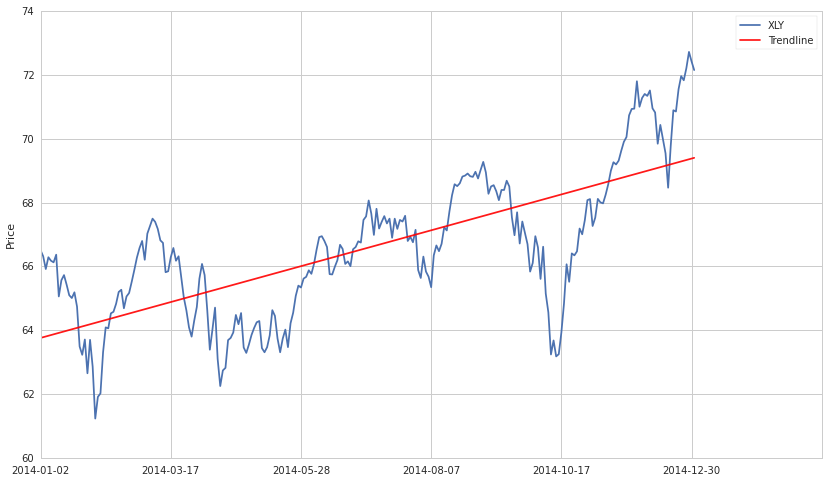

In [2]:
# Load pricing data for an asset
start = '2014-01-01'
end = '2015-01-01'
asset = get_pricing('XLY', fields='price', start_date=start, end_date=end)
dates = asset.index

# Plot the price of the asset over time
_, ax = plt.subplots()
ax.plot(asset)
ticks = ax.get_xticks()
ax.set_xticklabels([dates[i].date() for i in ticks[:-1]]) # Label x-axis with dates

# Find the line of best fit to illustrate the trend
X = np.arange(len(asset))
x = sm.add_constant(X) # Add a column of ones so that line can have a y-intercept
model = regression.linear_model.OLS(asset, x).fit()
a = model.params[0] # Get coefficients of line
b = model.params[1]
Y_hat = X * b + a
plt.plot(X, Y_hat, 'r', alpha=0.9);
plt.ylabel('Price')
plt.legend(['XLY', 'Trendline']);

The hypothesis here is that the motion of the stock is based on some upwards trend, captured by the linear model, plus some random noise.

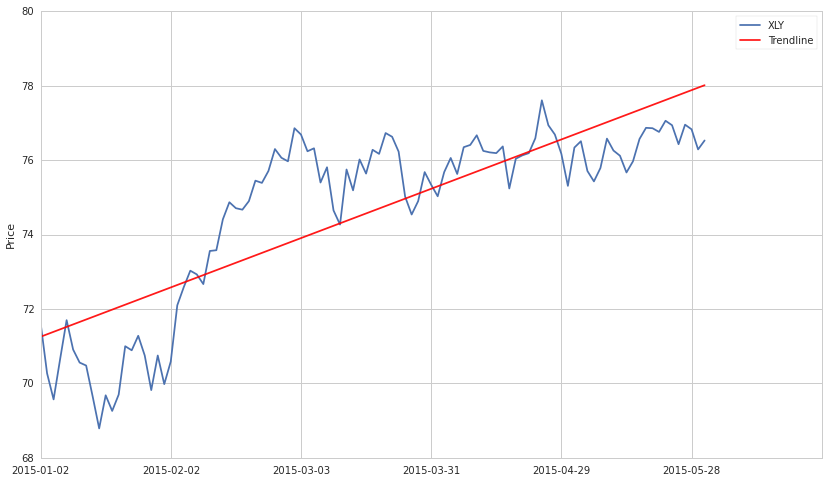

In [3]:
# Load pricing data for an asset
start = '2015-01-01'
end = '2015-06-01'
asset = get_pricing('XLY', fields='price', start_date=start, end_date=end)
dates = asset.index

# Plot the price of the asset over time
_, ax = plt.subplots()
ax.plot(asset)
ticks = ax.get_xticks()
ax.set_xticklabels([dates[i].date() for i in ticks[:-1]]) # Label x-axis with dates

# Find the line of best fit to illustrate the trend
X = np.arange(len(asset))
x = sm.add_constant(X) # Add a column of ones so that line can have a y-intercept
model = regression.linear_model.OLS(asset, x).fit()
a = model.params[0] # Get coefficients of line
b = model.params[1]
Y_hat = X * b + a
plt.plot(X, Y_hat, 'r', alpha=0.9);
plt.ylabel('Price')
plt.legend(['XLY', 'Trendline']);

##Momentum and Auto-Correlation

Many things in finance are autocorrelated. An intuitive explanation for this is that prices are determined by traders, which take into account past prices when determining new ones. The formula might be

$$P_t = T_t + \epsilon$$
$$T_t = X + P_{1, t-1}$$
$$P_t = X + P_{1, t-1} + \epsilon$$

Where X covers all the other factors traders consider and $\epsilon$ is random noise. This is the definition of an autocorrelated series, in which the value at time $t$ depends on previous values.

Some forms of autocorrelation will not exhibit momentum behavior. For instance, a very simple autocorrelation relation could be as follows.

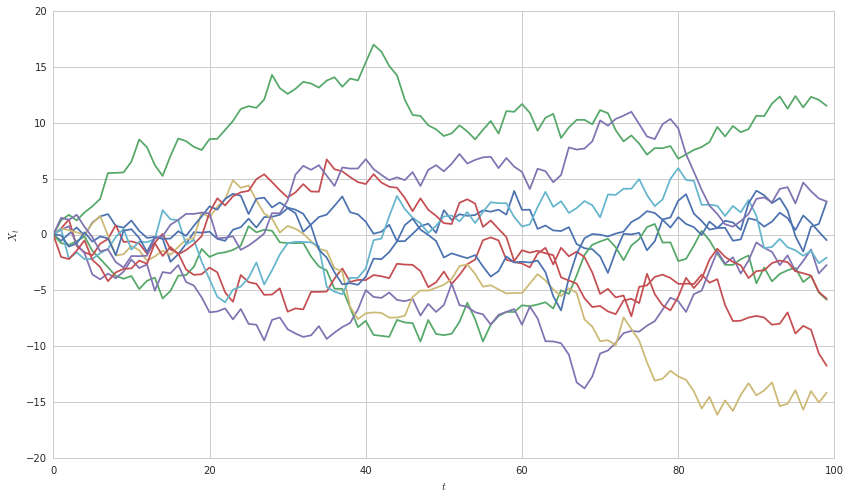

In [4]:
def generate_autocorrelated_values(N):
    X = np.zeros(N)
    for i in range(N-1):
        X[i+1] = X[i] + np.random.normal(0, 1)
    return X

for i in range(10):
    X = generate_autocorrelated_values(100)
    plt.plot(X)
plt.xlabel('$t$')
plt.ylabel('$X_t$');

These series will not exhibit momentum behavior, as the amount they go up and down each timestep is purely random. However, if the series' returns are autocorrelated, then we will see momentum behavior. We can simulate this as follows.

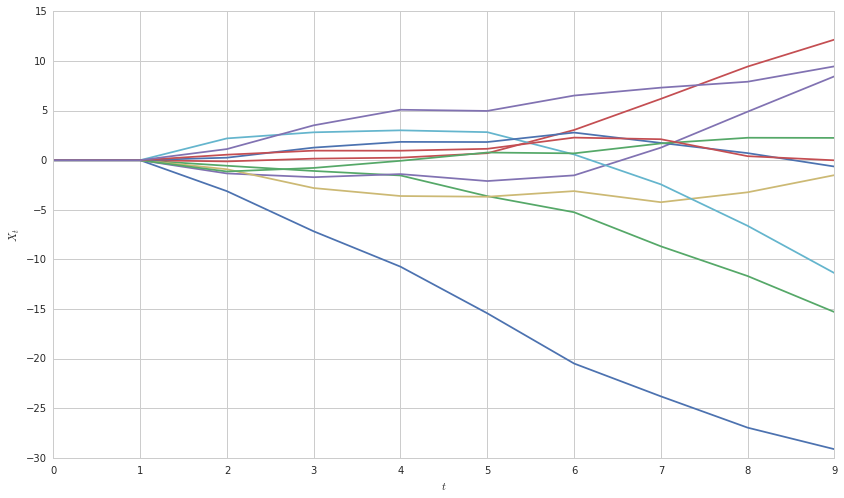

In [5]:
def generate_autocorrelated_values(N):
    X = np.zeros(N)
    for i in range(1, N-1):
        # Do the past returns 'look good' to investors
        past_returns = X[i] - X[i-1]
        # Investors hypothesize that future returns will be equal to past returns and buy at that price
        X[i+1] = X[i] + past_returns + np.random.normal(0, 1)
    return X

for i in range(10):
    X = generate_autocorrelated_values(10)
    plt.plot(X)
plt.xlabel('$t$')
plt.ylabel('$X_t$');

It's now clear to see that if investors incorporate information about past returns into the future price, we will see momentum behavior. Obviously in real data this will be far more noisy and difficult to observe.

###Testing for Autocorrelation

We can test for autocorrelation in a few ways. One is by checking for a unit root. If the series has a unit root, we should be worried that there is autocorrelation present.

In [6]:
from statsmodels.tsa.stattools import adfuller

X1 = generate_autocorrelated_values(100)
X2 = np.random.normal(0, 1, 100)

# Compute the p-value of the Dickey-Fuller statistic to test the null hypothesis that yw has a unit root
print 'X1'
_, pvalue, _, _, _, _ = adfuller(X1)
if pvalue > 0.05:
    print 'We cannot reject the null hypothesis that the series has a unit root.'
else:
    print 'We reject the null hypothesis that the series has a unit root.'
print 'X2'
_, pvalue, _, _, _, _ = adfuller(X2)
if pvalue > 0.05:
    print 'We cannot reject the null hypothesis that the series has a unit root.'
else:
    print 'We reject the null hypothesis that the series has a unit root.'

X1
We cannot reject the null hypothesis that the series has a unit root.
X2
We reject the null hypothesis that the series has a unit root.


##Momentum vs. Mean Reversion

Momentum and mean reversion are in a sense opposite strategies. In a momentum model one hypothesizes that past upwards movement is indicative of future upwards movement. In a mean reversion model one hypothesizes that past upward trends are simply temporary overvaluings and the price will return to normal. Both are important models that work in different cases.

It is important to check for which kind of behavior might be present in your data before you actually try developing a strategy based on that.

###Time Frame is Important

Momentum behavior and mean reversion behavior can both occur in the same asset. Take for example XLY again. We can see a trend upwards, but there is also movement around that trend. One approach could be to buy an hold XLY and attempt to make money on the longer timeframe. Another approach would be to buy XLY whenever it went under the trendline and sell it whenever it was beneath. This strategy would work on shorter timeframes.

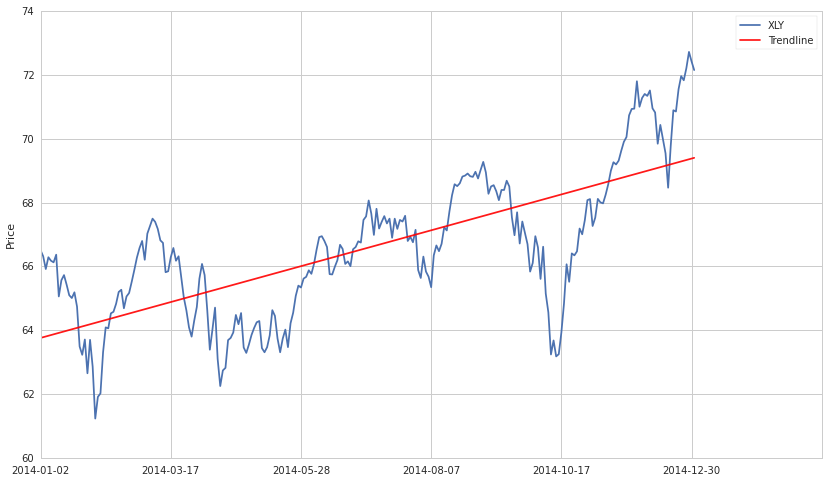

In [7]:
# Load pricing data for an asset
start = '2014-01-01'
end = '2015-01-01'
asset = get_pricing('XLY', fields='price', start_date=start, end_date=end)
dates = asset.index

# Plot the price of the asset over time
_, ax = plt.subplots()
ax.plot(asset)
ticks = ax.get_xticks()
ax.set_xticklabels([dates[i].date() for i in ticks[:-1]]) # Label x-axis with dates

# Find the line of best fit to illustrate the trend
X = np.arange(len(asset))
x = sm.add_constant(X) # Add a column of ones so that line can have a y-intercept
model = regression.linear_model.OLS(asset, x).fit()
a = model.params[0] # Get coefficients of line
b = model.params[1]
Y_hat = X * b + a
plt.plot(X, Y_hat, 'r', alpha=0.9);
plt.ylabel('Price')
plt.legend(['XLY', 'Trendline']);

To see how a mean reversion signal might look, let's look at the difference between the asset and the prediction. Sure enough, looks like some good opportunity for mean reversion as the price difference crosses the zero line many times.

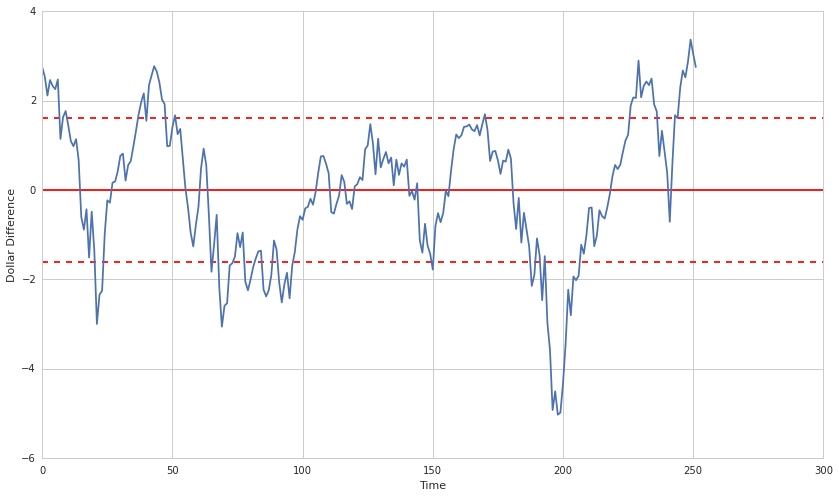

In [8]:
plt.plot(asset - Y_hat)
plt.hlines(np.mean(asset - Y_hat), 0, 300, colors='r')
plt.hlines(np.std(asset - Y_hat), 0, 300, colors='r', linestyles='dashed')
plt.hlines(-np.std(asset - Y_hat), 0, 300, colors='r', linestyles='dashed')
plt.xlabel('Time')
plt.ylabel('Dollar Difference');

###Time Frame is Important for Predictive Capacity

Each momentum measure will be predictive over different time horizons. Some over years and some over days. This will also be true of different asset classes. Some asset classes have momentum over years and some over days. It is important, when constructing a momentum model, to keep in mind what time frame makes sense. That time frame should be roughly the time frame on which you rebalance/exit the trade. It should also be the time frame you use when measuring predictive capacity of your model.

###IMPORTANT: Model Selection

It is important not to fall prey to statistical biases by throwing a lot of models at a dataset and seeing which fit. To understand why this is true, see other lectures in the series, especially The Dangers of Overfitting. In short, if you throw a lot of models at a dataset, one will likely happen to look good based on random chance. This model will not have predictive power on any new data, just the data you've already seen.

A better approach is to let your model creation be driven by underlying things you know to be true about your data. For instance, here is a good development path:
1. Hypothesize that based on investor psychology, certain stocks should exhibit momentum behavior.
2. Construct a mathemtical model that follows this hypothesis.
3. Test your hypothesis by seeing if that model fits your data well.
4. Test your model out of sample on new data you've never seen before.

##Trading on Momentum

###Measuring Momentum

To trade on momentum, we must first be able to measure it. For information on how to measure momentum, please see the Measuring Momentum lecture. Various ways to quantify momentum will be discussed there. We will discuss what you might do once you have developed a measure of momentum here.

All following examples will assume that a good measure of momentum $p$, has been developed. The notation $p(A_t)$ will denote the momentum of asset $A$ and time $t$.

###Entry and Exit Signals

One way to use momentum is to have cutoffs and enter a position when momentum is significantly high, and leave it when momentum is significantly low. The can be done for shorting stocks as well if momentum is in the negative direction. Good examples of this would be moving average crossover strategies, as discussed in the Measuing Momentum lecture.

###Ranking Stocks for Long-Short Baskets

Another approach is to use momentum as a factor for ranking stocks. The general approach and its benefits are descrbed in the Long-Short Equity and Ranking Universes by Factors lectures. In short, you make a bet that stocks with higher momentum will outperform those with lower momentum. This tends to be more market neutral and robust. Momentum could also be used as one of many factors in a ranking scheme.

####Cross-Sectional Momentum

Cross sectional momentum is when rather than looking at absolute momentum, you look at momentum of every stock relative to every other stock. This has the advantage of providing a relative scale, rather than a somewhat meaningless absolute measure of momentum. An example of this can be found in the algorithm associated with this lecture. To access it, go to the lectures page, hover over this lecture, and click "Get Backtest."

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*